In [ ]:
%load_ext autoreload
%autoreload 2

import tensorflow as tf
import torch
import lightning.pytorch as pl
from src.dataset.dataset import SubCellDatset, DatasetType
from src.model.full_model import SubCellProtModel
from src.utils.analysis_utils import call_model
from src.utils.data_handling_utils import initialize_datasets, Retrieval_Data
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd
import os
import seaborn as sns
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE
import pickle

In [2]:
COLLECTION_NAME="random_splice_isoform_dataset"
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(COLLECTION_NAME,if_alphabetical=False)
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)

In [4]:
from pymongo import MongoClient
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    isoform_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$splice_isoform_id", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [5]:
cell_line_grouping = None
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa[COLLECTION_NAME]
    cell_line_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$cell_line", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )

In [6]:
testCellLines=np.array(['HeLa','MCF7', 'GAMG', 'HEK293',  'A549', 'U251MG','NB4', 'THP1'])
cellIDbyCellLine={}
for clidx in cell_line_grouping:
    if clidx['_id'] in testCellLines:
        cellIDbyCellLine[clidx['_id']]=np.array(clidx['ids'])

In [7]:
testIsoforms=np.array(['ATP13A5-201','CHID1-201','COPA-208','DDIT3-202','EIF4G1-206','EIF3G-202','CDK16-216','ATXN10-212','MESD-201','N4BP2-201','PSME3IP1-217','RBM23-203'])
testIsoform_groupName=np.array(['variable_cell_line','variable_cell_line','variable_cell_line','variable_single_cell','least_variable_outside','least_variable_outside','least_variable_outside','least_variable_outside','variable_cell_line','variable_single_cell','least_variable_inside','variable_cell_line'])
testIsoform_input=[None]*testIsoforms.size
for pidx in range(len(isoform_grouping)):
    p=isoform_grouping[pidx]['_id']
    if p not in testIsoforms:
        continue
    print(p)
    testIsoform_input[testIsoforms.tolist().index(p)] = get_data(isoform_grouping[pidx]['ids'][0], Retrieval_Data.PROTEIN_SEQ)


EIF3G-202
RBM23-203
N4BP2-201
EIF4G1-206
MESD-201
PSME3IP1-217
CDK16-216
ATXN10-212


In [8]:
cellIDbyCellLine.keys()

dict_keys(['MCF7', 'HeLa', 'U251MG', 'HEK293', 'GAMG', 'A549'])

In [14]:
nucProp_landmarks={}
nucProp_mask={}
nsamples_all=200
for clidx in range(testCellLines.size):
    cl=testCellLines[clidx]
    if cl not in cellIDbyCellLine.keys():
        continue
    print(cl)

    nsamples=min(nsamples_all,cellIDbyCellLine[cl].size)
    sampleIdx=np.arange(cellIDbyCellLine[cl].size)
    np.random.seed(3)
    np.random.shuffle(sampleIdx)
    cellID_cl=cellIDbyCellLine[cl][sampleIdx[:nsamples]]
    
    nucProp_landmarks[cl]=[None]*nsamples
    nucProp_mask[cl]=[None]*nsamples
    for cIdx in range(nsamples):
        X_landmark_stains = get_data(cellID_cl[cIdx], Retrieval_Data.CELL_IMAGE)
        nucProp_landmarks[cl][cIdx]=X_landmark_stains
        

MCF7
U251MG
GAMG
HeLa
A549
HEK293


In [10]:
COLLECTION_NAME="splice_isoform_dataset_cell_line_and_gene_split_full"
MODEL_CHECKPOINT='checkpoints/splice_isoform_dataset_cell_line_and_gene_split_full-epoch=01-val_combined_loss=0.18.ckpt'
train_dataset, val_dataset, test_dataset, get_data = initialize_datasets(COLLECTION_NAME,if_alphabetical=True)
loaded_model = SubCellProtModel().load_from_checkpoint(
    MODEL_CHECKPOINT,
    collection_name=COLLECTION_NAME,
    batch_size=32,
)

Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up


In [11]:
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa_old[COLLECTION_NAME]
    isoform_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$splice_isoform_id", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )
with MongoClient(maxPoolSize=500) as client:
    dataset_collection = client.hpa_old[COLLECTION_NAME]
    cell_line_grouping = list(
        dataset_collection.aggregate(
            [{"$group": {"_id": "$cell_line", "ids": {"$push": "$_id"}}}],
            allowDiskUse=True,
        )
    )
for clidx in cell_line_grouping:
    if clidx['_id'] in testCellLines:
        cellIDbyCellLine[clidx['_id']]=np.array(clidx['ids'])
cellIDbyCellLine.keys()

dict_keys(['MCF7', 'HeLa', 'U251MG', 'HEK293', 'GAMG', 'A549', 'NB4', 'THP1'])

In [12]:
testIsoforms=np.array(['ATP13A5-201','CHID1-201','COPA-208','DDIT3-202','EIF4G1-206','EIF3G-202','CDK16-216','ATXN10-212','MESD-201','N4BP2-201','PSME3IP1-217','RBM23-203'])
testIsoform_groupName=np.array(['variable_cell_line','variable_cell_line','variable_cell_line','variable_single_cell','least_variable_outside','least_variable_outside','least_variable_outside','least_variable_outside','variable_cell_line','variable_single_cell','least_variable_inside','variable_cell_line'])
for pidx in range(len(isoform_grouping)):
    p=isoform_grouping[pidx]['_id']
    if p not in testIsoforms:
        continue
    print(p)
    testIsoform_input[testIsoforms.tolist().index(p)] = get_data(isoform_grouping[pidx]['ids'][0], Retrieval_Data.PROTEIN_SEQ)


CDK16-216
DDIT3-202
ATXN10-212
CHID1-201
COPA-208
ATP13A5-201
EIF4G1-206
EIF3G-202


In [33]:
nsamples_all=200
for clidx in range(testCellLines.size):
    cl=testCellLines[clidx]
    if cl not in cellIDbyCellLine.keys():
        continue
    print(cl)

    nsamples=min(nsamples_all,cellIDbyCellLine[cl].size)
    sampleIdx=np.arange(cellIDbyCellLine[cl].size)
    np.random.seed(3)
    np.random.shuffle(sampleIdx)
    cellID_cl=cellIDbyCellLine[cl][sampleIdx[:nsamples]]
    
    nucProp_landmarks[cl]=[None]*nsamples
    nucProp_mask[cl]=[None]*nsamples
    for cIdx in range(nsamples):
        X_landmark_stains = get_data(cellID_cl[cIdx], Retrieval_Data.CELL_IMAGE)
        nucProp_landmarks[cl][cIdx]=X_landmark_stains
        

HeLa
MCF7
GAMG
HEK293
A549
U251MG
NB4
THP1


In [36]:
OUTPUT_PKL_FILE = "results/processed_matrix_newModel_validationCLp_joint.pkl"

jointembedding=np.zeros((testIsoforms.size,testCellLines.size,256*32*32))


if os.path.exists(OUTPUT_PKL_FILE):
    embedding_df = pd.read_pickle(OUTPUT_PKL_FILE)
else:
    embedding_df = pd.DataFrame(
        columns=[
            "idx",
            "cell_line",
            "splice_variant_id",
            "activation",
            "y_pred_multilabel"
        ]
    )
    embedding_df.set_index('idx', inplace=True)

nsamples_all=100
cell_idx=0
for clidx in range(testCellLines.size):
    cl=testCellLines[clidx]
    print(cl)
    for pidx in range(testIsoforms.size):
        p=testIsoforms[pidx]
        print(p)
        X_esm2_encoding, X_protein_len=testIsoform_input[pidx]
        
        nsamples=min(nsamples_all,len(nucProp_landmarks[cl]))
        for cIdx in range(nsamples):
            X_landmark_stains = nucProp_landmarks[cl][cIdx]
            
            y_pred_multilabel, y_pred_antibody_stain_pred, activation = call_model(
                loaded_model,X_esm2_encoding, X_protein_len, X_landmark_stains, embedding_hooks=['cell_embedding', 'protein_embedding','joint_embedding']
            )
            
            embedding_df.loc[cell_idx] = pd.Series(
                {
                    "cell_line": cl,
                    "splice_variant_id": p,
                    "activation": activation,
                    "y_pred_multilabel": y_pred_multilabel,
                }
            )
            if cell_idx % 1000 == 0:
                embedding_df.to_pickle(OUTPUT_PKL_FILE)
            cell_idx+=1




HeLa
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
EIF3G-202
CDK16-216
ATXN10-212
MESD-201
N4BP2-201
PSME3IP1-217
RBM23-203
MCF7
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
EIF3G-202
CDK16-216
ATXN10-212
MESD-201
N4BP2-201
PSME3IP1-217
RBM23-203
GAMG
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
Cleaning up...
Finished cleaning up
EIF3G-202
CDK16-216
ATXN10-212
MESD-201
N4BP2-201
PSME3IP1-217
RBM23-203
HEK293
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
EIF3G-202
CDK16-216
ATXN10-212
MESD-201
N4BP2-201
PSME3IP1-217
RBM23-203
A549
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
EIF3G-202
CDK16-216
ATXN10-212
MESD-201
N4BP2-201
PSME3IP1-217
RBM23-203
U251MG
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
EIF3G-202
CDK16-216
ATXN10-212
MESD-201
N4BP2-201
PSME3IP1-217
RBM23-203
NB4
ATP13A5-201
CHID1-201
COPA-208
DDIT3-202
EIF4G1-206
EIF3G-202
CDK16-

In [37]:
embedding_df.to_pickle(OUTPUT_PKL_FILE)

In [124]:
def show_embedding(plotting_df, x_lab='PC1', y_lab='PC2', hue_lab='labels',savepath=None):
    hue_order = sorted(set(plotting_df[hue_lab]))
    ax = sns.scatterplot(
        data=plotting_df,
        x=x_lab,
        y=y_lab,
        style=hue_lab,
        hue=hue_lab,
        hue_order=hue_order,
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    if savepath is None:
        plt.show()
    else:
        plt.tight_layout()
        plt.savefig(savepath,dpi=600)

### Cell line embedding

In [14]:
embedding_df=pd.read_pickle("results/processed_matrix_newModel_validationCLp_joint.pkl")

Cleaning up...
Finished cleaning up


In [16]:
embedding_df

,cell_line,splice_variant_id,activation,y_pred_multilabel
idx,,,,
0,HeLa,ATP13A5-201,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00024498868, 0.00073809543, 0.00036581384,..."
1,HeLa,ATP13A5-201,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00024498868, 0.00073809543, 0.00036581384,..."
2,HeLa,ATP13A5-201,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00024498868, 0.00073809543, 0.00036581384,..."
3,HeLa,ATP13A5-201,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00024498868, 0.00073809543, 0.00036581384,..."
4,HeLa,ATP13A5-201,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00024498868, 0.00073809543, 0.00036581384,..."
...,...,...,...,...
9595,THP1,RBM23-203,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00021155267, 0.00055844535, 0.0010767207, ..."
9596,THP1,RBM23-203,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00021155267, 0.00055844535, 0.0010767207, ..."
9597,THP1,RBM23-203,"{'protein_embedding': [[tensor(0.1815), tensor...","[[0.00021155267, 0.00055844535, 0.0010767207, ..."


In [47]:
cl_embedding=np.zeros((embedding_df.shape[0],embedding_df['activation'][0]['cell_embedding'].numpy().flatten().size))
cl_name=np.copy(embedding_df['cell_line'])
for cl_i in range(cl_embedding.shape[0]):
    cl_embedding[cl_i]=embedding_df['activation'][cl_i]['cell_embedding'].numpy().flatten()

In [48]:
pca_cl=PCA(n_components=30)
pca_cl.fit(cl_embedding)
cl_pca=pca_cl.transform(cl_embedding)

In [49]:
with open('results/pca_cl_validationCLp', 'wb') as output:
    pickle.dump(pca_cl, output, pickle.HIGHEST_PROTOCOL)
with open('results/cl_pcatransformed_validationCLp', 'wb') as output:
    pickle.dump(cl_pca, output, pickle.HIGHEST_PROTOCOL)

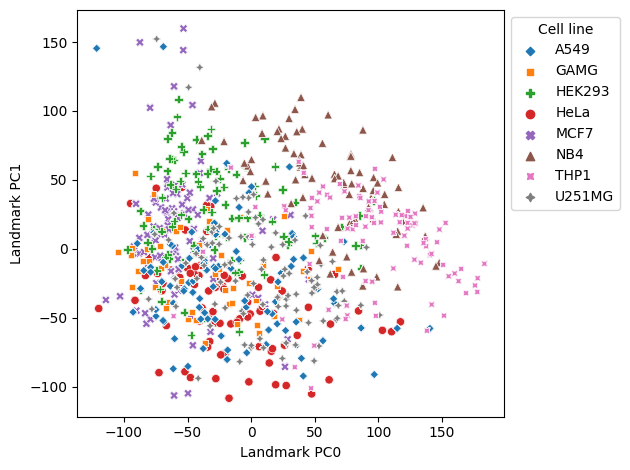

In [125]:
pc1=0
pc2=1
plotting_df = pd.DataFrame(
    {"Cell line":cl_name,
     "Landmark PC"+str(pc1):cl_pca[:,pc1],
     "Landmark PC"+str(pc2):cl_pca[:,pc2],
    }
)
show_embedding(plotting_df,'Landmark PC'+str(pc1),'Landmark PC'+str(pc2),'Cell line','results/cell_line_pca01.jpg')

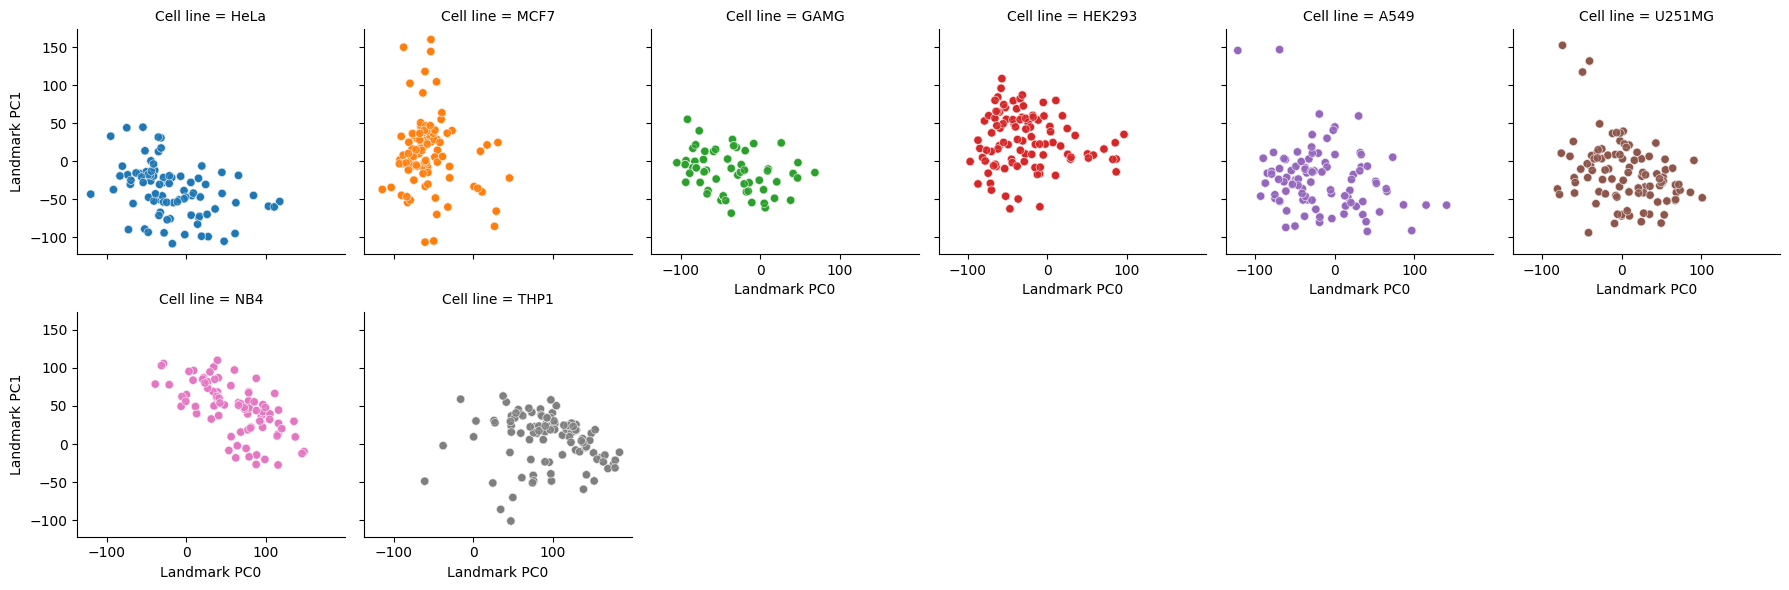

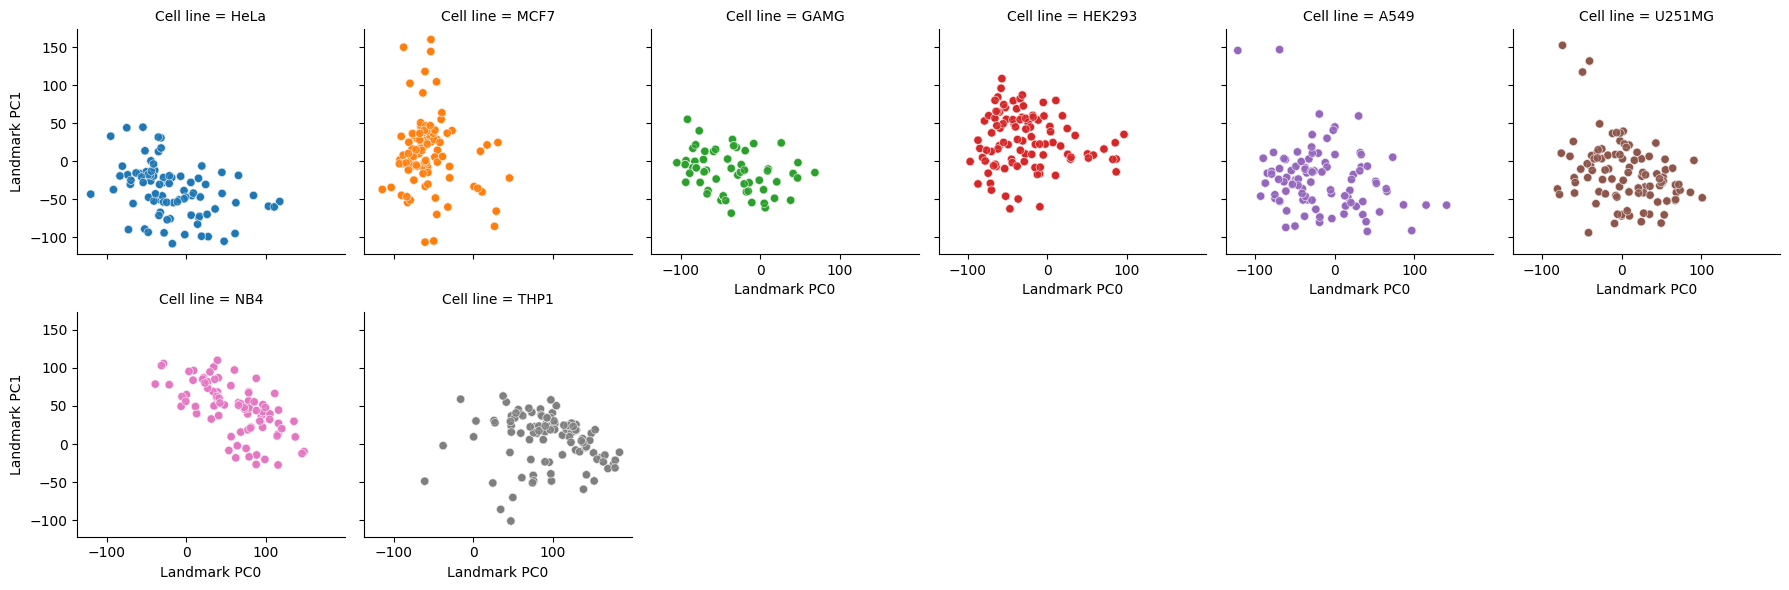

In [53]:
pc1=0
pc2=1
plotting_df = pd.DataFrame(
    {"Cell line":cl_name,
     "Landmark PC"+str(pc1):cl_pca[:,pc1],
     "Landmark PC"+str(pc2):cl_pca[:,pc2],
    }
)
g = sns.FacetGrid(
    plotting_df, col='Cell line', col_wrap=6, hue='Cell line'
)
g.map_dataframe(
    sns.scatterplot,
    data=plotting_df,
    x="Landmark PC"+str(pc1),
    y="Landmark PC"+str(pc2),
    alpha=0.7,
    style='Cell line',
)
plt.show()

### joint embedding

In [56]:
joint_embedding=np.zeros((embedding_df.shape[0],embedding_df['activation'][0]['joint_embedding_after_upsample_layer1'].numpy().flatten().size))
joint_cl_name=np.copy(embedding_df['cell_line'])
joint_p_name=np.copy(embedding_df['splice_variant_id'])
for j_i in range(joint_embedding.shape[0]):
    joint_embedding[j_i]=embedding_df['activation'][j_i]['joint_embedding_after_upsample_layer1'].numpy().flatten()
    

In [58]:
pca_j=PCA(n_components=30)
pca_j.fit(joint_embedding)
j_pca=pca_j.transform(joint_embedding)

In [59]:
with open('results/pca_joint_validationCLp', 'wb') as output:
    pickle.dump(pca_j, output, pickle.HIGHEST_PROTOCOL)
with open('results/joint_pcatransformed_validationCLp', 'wb') as output:
    pickle.dump(j_pca, output, pickle.HIGHEST_PROTOCOL)

In [88]:
def show_embedding_joint(plotting_df, x_lab='PC1', y_lab='PC2', hue_lab='labels',style='shapelabels',size=1):
    hue_order = sorted(set(plotting_df[hue_lab]))
    ax = sns.scatterplot(
        data=plotting_df,
        x=x_lab,
        y=y_lab,
        style=style,
        hue=hue_lab,
        hue_order=hue_order,
        s=size
    )
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.show()

In [64]:
#averaging pc of pairs
pname_pair=np.tile(testIsoforms,testCellLines.size)
pgroup_pair=np.tile(testIsoform_groupName,testCellLines.size)
clname_pair=np.repeat(testCellLines,testIsoforms.size)
joint_meanPCA=np.zeros((pname_pair.size,30))


In [65]:
for pidx in range(pname_pair.size):
    p=pname_pair[pidx]
    cl=clname_pair[pidx]
    pclIdx=np.logical_and(joint_cl_name==cl,joint_p_name==p)
    joint_meanPCA[pidx]=np.mean(j_pca[pclIdx],axis=0)

In [68]:
#average joint then pca
jointmean=np.zeros((pname_pair.size,joint_embedding.shape[1]))
for pidx in range(pname_pair.size):
    p=pname_pair[pidx]
    cl=clname_pair[pidx]
    pclIdx=np.logical_and(joint_cl_name==cl,joint_p_name==p)
    jointmean[pidx]=np.mean(joint_embedding[pclIdx],axis=0)

In [69]:
pca_jmean=PCA(n_components=30)
pca_jmean.fit(jointmean)
jmean_pca=pca_j.transform(jointmean)

In [97]:
from matplotlib import colormaps
colormaps['tab10'].colors[:7]

((0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902))

In [109]:
clmean=np.zeros((testCellLines.size,30))
for clidx in range(testCellLines.size):
    clmean[clidx]=np.mean(jmean_pca[clname_pair==sorted(testCellLines)[clidx]],axis=0)
    

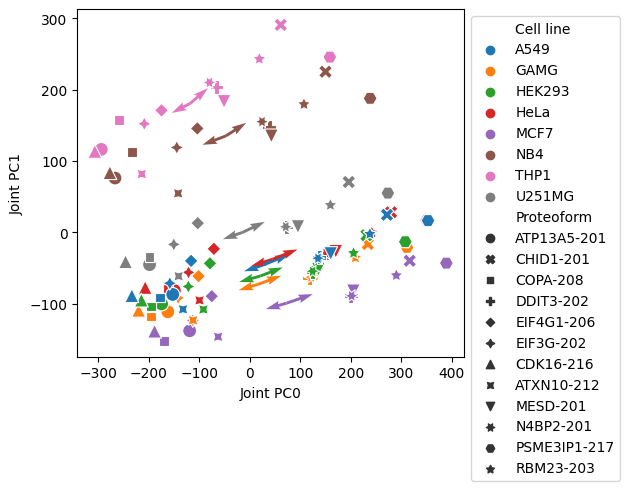

In [126]:
isoforms2plot=['ATP13A5-201','CHID1-201']
pc1=0
pc2=1
plotting_df = pd.DataFrame(
    {"Cell line":clname_pair,
     'Proteoform':pname_pair,
     "Joint PC"+str(pc1):jmean_pca[:,pc1],
     "Joint PC"+str(pc2):jmean_pca[:,pc2],
    }
)
fig, ax = plt.subplots()
    
hue_lab='Cell line'
style='Proteoform'
hue_order = sorted(set(plotting_df[hue_lab]))
ax = sns.scatterplot(
    data=plotting_df,
    x="Joint PC"+str(pc1),
    y="Joint PC"+str(pc2),
    style=style,
    hue=hue_lab,
    hue_order=hue_order,
    s=100
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

for pidx in range(len(isoforms2plot)):
    
    pclmean=np.zeros((testCellLines.size,30))
    for clidx in range(testCellLines.size):
        pclmean[clidx]=jmean_pca[np.logical_and(clname_pair==sorted(testCellLines)[clidx],pname_pair==isoforms2plot[pidx])]

    
    
    ax.quiver(clmean[:,0],clmean[:,1],pclmean[:,0]-clmean[:,0],pclmean[:,1]-clmean[:,1],angles='xy',color=colormaps['tab10'].colors,scale=3500)
plt.tight_layout()
plt.savefig('results/joint_pca_arrow.jpg',dpi=600)